# How to use Mask objects

In this tutorial, we go over the importance of masks and how they are made and used. 

First import `specpolFlow` and any other packages.

In [1]:
## Importing Necessary Packages
import specpolFlow as pol

import pandas as pd
import numpy as np

## What is a Mask?

Analytically, a mask is a function with Dirac deltas at wavelengths corresponding to specific spectral lines. The amplitude of the Dirac delta function corresponds to the line depth. Numerically, a mask is an array of wavelengths with a depth at the center of each line. Thus, a **mask tells us the location and depth of all lines** in a spectrum but does not tell us about the shape of the lines or the spectrum as a whole.

## Why do we care?

The idea behind LSD is to model a spectrum as the convolution of a line mask and a line profile (the LSD profile).  So given an LSD profile and a mask, we can convolve the LSD profile with the mask to get a model spectrum. Typically, though, we have an observed spectrum and a mask but want the LSD profile. This reverse process of going from a spectrum and a line mask to an LSD profile is called deconvolution. **We need a mask to help us weigh each spectral line in the spectrum so that they can be combined into an LSD profile**.

## Mask creation 

We will use the <a href='../API/Mask_API.html#specpolFlow.make_mask'>make_mask</a> function to create a mask. Usually you will only need the arguments *lineListFile* and *outMaskName*, as well as two optional arguments, *depthCutoff* and *atomsOnly*.

```{margin}

:::{seealso}
You can see the [Mask API](https://folsomcp.github.io/specpolFlow/API/Mask_API.html) for more information on available kwargs.
:::

```

- `lineListFile` is the name of the file containing the line list;
- `outMaskName` is the name of the file to write the output mask to (default is None);
- `depthCutoff` is a float that only include lines in the mask that are deeper than this value;
- `atomsOnly` is a boolean that decides whether to include only atomic lines (no molecular lines and no H-lines).

```{note}
Hydrogen lines are automatically excluded when `atomsOnly = True`. This is done because the hydrogen lines, due to their broad wings, have a different shape than all the other lines in the spectrum.
```

The input line list is a VALD line list file obtained from the [VALD website](http://vald.astro.uu.se). It should be an "extract stellar" from VALD in their "long" format (to include Landé factors), and it should correspond to the $T_\text{eff}$, $\log g$, and chemical abundances of your star.  More details about VALD are given in the tutorial {doc}`../GetStarted/OneObservationFlow_Tutorial`. In the example below, we start with a line list for a relatively hot star ([LongList_T27000G35.dat](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat)). We use all atomic lines in the line list stronger than 0.02, except those without effective Landé factors and the H-lines. 

In [2]:
LineList_file_name = '../GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat'
Mask_file_name = '../GetStarted/OneObservationFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'

mask_clean = pol.make_mask(LineList_file_name, outMaskName=Mask_file_name, 
                           depthCutoff = 0.02, atomsOnly = True)

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']


:::{warning}
The `make_mask` function will automatically attempt to calculate the **effective Landé factor** for lines missing that value in the line list. It can usually make approximate estimates for lines in LS, JJ, and JK coupling schemes.

However, if a Landé factor is unable to be calculated the line will be excluded if `includeNoLande = False` (the default), or the Landé factor will equal the `DefaultLande` value if `includeNoLande = True`.
:::

## Mask Cleaning

After obtaining our mask, the next step is to clean it. **Mask cleaning** involves removing lines that we do not want to use in the computation of LSD profiles. Typically, we exclude lines that fall within the **Telluric regions** and those within the **H line wings**. The lines within the Telluric regions are contaminated by lines from Earth's atmosphere and are therefore unusable. Hydrogen lines can't be modelled correctly in LSD because they have a different sizes and shapes from other lines.  So lines in the H wings, blended with Hydrogen lines, also can't be modelled correctly and are unusable.  Lines blended with other big broad absorption features, such as the Ca H & K lines in cooler star, should also be excluded. Although these will vary with the spectra type of the star. When dealing with stars with emission, care should be taken to **exclude emission lines** as they have different shapes.

This tutorial will clean the mask using some already defined regions (see {doc}`./4-ExcludeMaskRegionClass_Tutorial` for more details). For a more detailed by hand approach see {doc}`./3b-MaskUI_Tutorial`. First we get the pre-defined telluric regions with <a href='../API/Mask_API.html#specpolFlow.get_telluric_regions_default'>get_telluric_regions_default</a> and pre-defined hydrogen Balmer line regions with <a href='../API/Mask_API.html#specpolFlow.get_Balmer_regions_default'>get_Balmer_regions_default</a>.

In [3]:
# inputs
velrange = 600.0 # width of region on either side of a Balmer line to exclude, as a velocity, in km/s
# get the two sets of excluded regions and combine them
excluded_regions = pol.get_Balmer_regions_default(velrange) + pol.get_telluric_regions_default()

# optionally, display the excluded regions using Pandas
pd.DataFrame(excluded_regions.to_dict())

,start,stop,type
0,654.967529,657.594471,Halpha
1,485.167047,487.112953,Hbeta
2,433.181299,434.918701,Hgamma
3,409.349092,410.990908,Hdelta
4,396.215430,397.804570,Hepsilon
5,360.000000,392.000000,Hjump
6,587.500000,592.000000,telluric
7,627.500000,632.500000,telluric
8,684.000000,705.300000,telluric
9,717.000000,735.000000,telluric


Once we have our excluded regions, we can clean the mask using the `mask.clean` function. This function operates on an existing mask (it is part of the <a href='../API/Mask_API.html#specpolFlow.Mask'>Mask</a> class) and it takes the excluded regions. The output is a cleaned line mask, in which lines that fall within the `excluded_regions` have been removed. Finally we need to save the cleaned mask to a file using the mask's `save` function.


In [4]:
# reading in the mask that we created earlier
mask = pol.read_mask('../GetStarted/OneObservationFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask')

# applying the ExcludeMaskRegions that we created
mask_clean = mask.clean(excluded_regions)

# saving the new mask to a file
mask_clean.save('../GetStarted/OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask')

## Other useful tools

1. **Interactive Line Cleaning**

    SpecpolFlow also includes an interactive tool to visually inspect a mask, select/deselect lines, and compare an observation with the LSD model spectrum calculated on the fly. This can be useful for fine tuning a mask. See [How to clean masks with the interactive tool](3b-MaskUI_Tutorial.md). 

1.  **Prune**

    Additionally, the Mask class has a function to `prune` the mask object, removing all lines from the list that have `iuse = 0`.  The `clean` function works by setting the flag `iuse = 0` for lines, making them not used in a LSD calculation, but not deleting them from the line list completely.  Calling `prune` after calling `clean` can be used to remove the lines completely.

In [5]:
# using the mask that we created earlier, and re-running the clean function
mask_clean = mask.clean(excluded_regions)
print('Number of lines in the clean mask with iuse = 0: {}, from a total of: {}'.format(
    len(mask_clean[mask_clean.iuse == 0]), len(mask_clean)))

mask_clean_prune=mask_clean.prune()
print('Number of lines in the pruned mask with iuse = 0: {}, from a total of: {}'.format(
    len(mask_clean_prune[mask_clean_prune.iuse == 0]), len(mask_clean_prune)))

Number of lines in the clean mask with iuse = 0: 533, from a total of: 1601
Number of lines in the pruned mask with iuse = 0: 0, from a total of: 1068


::::{margin}
:::{attention}
Here, lines with `iuse = 0` are also included, so make sure to prune the mask beforehand. 
:::
::::

3. **Get Line Weights**

    We can calculate the LSD weight of all lines in the mask using the `get_weights` function. This function requires the following inputs:
    * `normDepth`: the normalizing line depth, as used for LSD;
    * `normWave`: the normalizing wavelength in nm; 
    * `normLande`: the normalizing effective Landé factor.
    
    The function then outputs two arrays, the weights of the Stokes I lines, and the weights of the Stokes V lines. Stokes I weights are generally the line depth divided by `normDepth`.  Stokes V weights are (line depth * wavelength * Lande factor)/(`normDepth` * `normWave` * `normLande`).

In [6]:
weightI, weightV = mask_clean_prune.get_weights(normDepth=0.2, normWave=500.0, normLande=1.2)

print(weightI)
print(weightV)

[1.735 1.99  0.14  ... 0.25  0.285 0.335]
[1.51113292 1.52142026 0.08239234 ... 0.39070416 0.4466502  0.52675226]


## Advanced mask filtering

The Mask class supports slicing and advanced slicing like numpy.  A Mask object is essentially a container for a set of numpy arrays.  This means you can get a line, or range of lines, from a mask using standard syntax like `mask[index_start:index_end]`.  This is most useful if you want to filter an existing Mask object to get only some types of lines in the mask.

In [7]:
# Get only lines deeper than some value
mask_deep = mask_clean_prune[mask_clean_prune.depth > 0.2]
print('total lines:', len(mask_clean_prune))
print('deep lines:', len(mask_deep))

# Get only lines in some wavelength range
mask_wl_range = mask_clean_prune[(mask_clean_prune.wl > 450.) & (mask_clean_prune.wl < 600.)]
print('mid wavelength lines:', len(mask_wl_range))

# Get only lines with larger effective Lande factors
mask_highLande = mask_clean_prune[mask_clean_prune.lande > 1.2]
print('high Lande lines:', len(mask_highLande))

# Line lists can be sliced based on element type.
# The elements codes use the format atomic number + ionization*0.01
# so they need to be rounded off before comparing numerically.
# For a line list with only iron:
mask_Fe = mask_clean_prune[np.round(mask_clean_prune.element).astype(int) == 26]
print('Fe lines:', len(mask_Fe))
# Or for a line list with no He:
mask_noHe = mask_clean_prune[np.round(mask_clean_prune.element).astype(int) != 2]
print('non-He lines:', len(mask_noHe))

# These can be combined, with numpy's logic functions.
# The parentheses are important for evaluating expressions th the right order.
# e.g. to get only strong iron lines in some wavelength range:
mask_short = mask_clean_prune[(mask_clean_prune.depth > 0.2) & 
                              (mask_clean_prune.wl > 450.) & (mask_clean_prune.wl < 600.) &
                              (np.round(mask_clean_prune.element).astype(int) == 26)]
print('strong Fe lines in wavelength range:', len(mask_short))
print('wavelengths', mask_short.wl)
print('elements', mask_short.element)
print('depths', mask_short.depth)

#If you want to save the filtered mask for later use
mask_short.save('../GetStarted/OneObservationFlow_tutorialfiles/test_output/T27000G35_Fe_depth0.2.mask')

total lines: 1068
deep lines: 160
mid wavelength lines: 444
high Lande lines: 422
Fe lines: 270
non-He lines: 1024
strong Fe lines in wavelength range: 5
wavelengths [512.7371 515.6111 524.3306 583.3938 592.9685]
elements [26.02 26.02 26.02 26.02 26.02]
depths [0.21  0.263 0.25  0.262 0.213]


## Plotting masks and using masks as line lists

The Mask class doesn't have a handy plotting function, but there is a plotting function for the LineList class.  And the Mask class has a function for converting it to a LineList object: `convert_to_line_list`.  The LineList object created by `convert_to_line_list` only contains the wavelengths, atomic species, lower level energies, effective Landé factors, and depth estimates from the mask.  The other fields are left at zero, since the Mask object doesn't contain information about them.  By default `convert_to_line_list` will only include lines from the mask with the `iuse == 1`.  

The function `plot_LineList` provides options for plotting the line list (see the  <a href='../API/LineList_API.html#specpolFlow.plot_LineList'>plot_LineList docs</a> for a variety of formatting options).  Here is a basic example of how to use that, and view a portion of the Mask.  The vertical ticks in this plot are proportional to the depth value in the mask.

(497.0, 507.0)

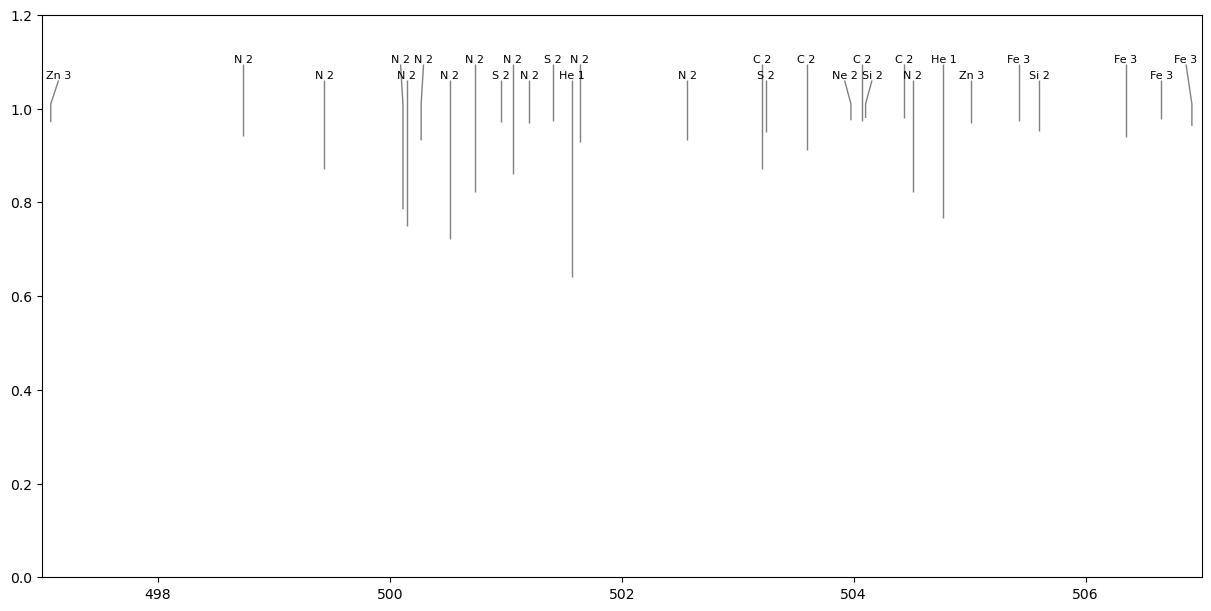

In [8]:
# Convert a mask to a LineList, and then plot it
list_from_mask = mask_clean.convert_to_line_list()
fig, ax = pol.plot_LineList(list_from_mask)
ax.set_xlim(497., 507.)

There is also a convenient function for plotting sets of Spectrum objects and LineList objects: `plot_obs_lines`.  (There are some formatting options in the plot_obs_lines docs, although it is less flexible than `plot_LineList`.)  This function takes a list of spectra to plot, and then a list of line lists to plot.  These can be either Spectrum and LineList objects, or files that can be read as those objects.  

(0.5, 1.2)

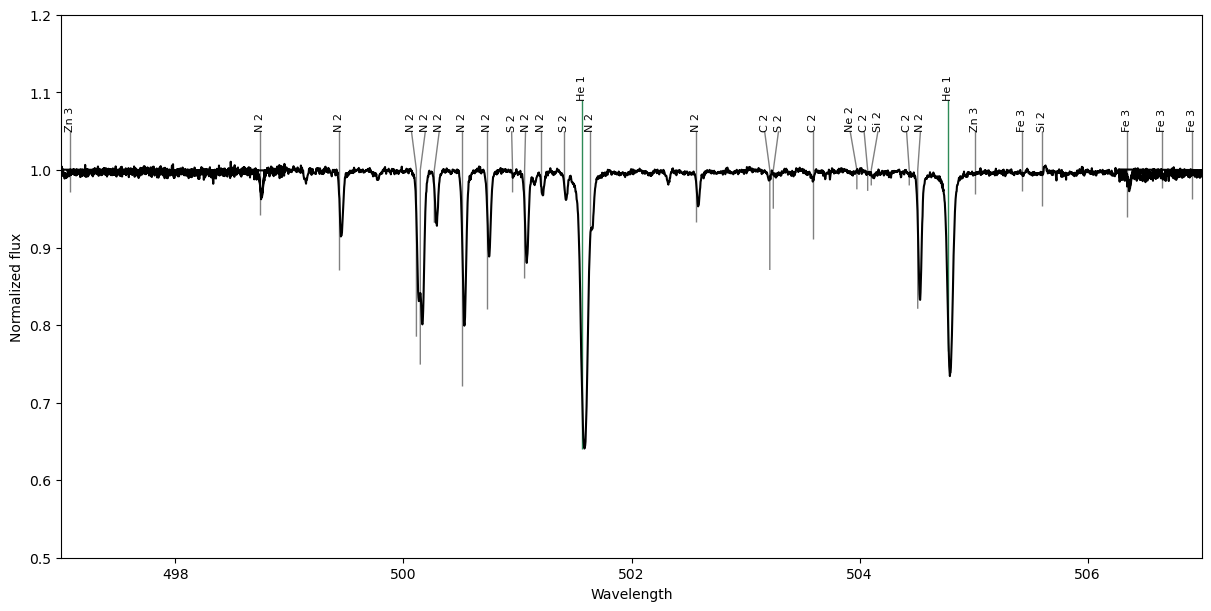

In [9]:
# Make two masks, one containing only He lines (He I or He II), and the other with all other metal lines.
mask_He = mask_clean[(mask_clean.element == 2.0) | (mask_clean.element == 2.1)]
mask_metals = mask_clean[(mask_clean.element != 2.0) & (mask_clean.element != 2.1)]

# Convert those masks to LineList objects
lineList_He = mask_He.convert_to_line_list()
lineList_metals = mask_metals.convert_to_line_list()

# Plot an observation and those two line lists
fig, ax = pol.plot_obs_lines('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s.norm', 
                             lineList=[lineList_metals, lineList_He])
ax.set_xlim(497., 507.)
ax.set_ylim(0.5, 1.2)

# With the order that the LineLists are passed into the function, the one without He is the lower
# set of labels with grey ticks, while the He list is plotted  above that with green ticks.